
### 1. Análisis y pronóstico de series de tiempo

- Seleccionar una base de datos con al menos una serie de tiempo univariada (se sugiere además considerar variables adicionales para generar un enfoque multivariado que se usará posteriormente).
- Aplicar un modelo de pronóstico **lineal clásico** (por ejemplo, SARIMAX) **solo para el caso univariado**. Recuerda usar y argumentar todo el análisis que debe ser realizado para este tipo de modelos.
- Evaluar el desempeño del modelo lineal como línea base (Usar métricas como MAPE, MSE y $R^2$).

In [1]:
import pandas as pd
import seaborn as snsimport
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, r2_score
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.layers import Conv1D, Flatten
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
import optuna
from mlflow_runs import MLflowCallback
mlflow_callback = MLflowCallback()

/Users/daftamayo/Downloads/Air_Quality_Pred_Clas-main/.vnev/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv("Data/air_quality_clean.csv")
df

,Datetime,CO(GT),PT08.S1(CO),C6H6(GT),PT08.S2(NMHC),PT08.S3(NOx),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
0,2004-03-10 18:00:00,2.6,1360.0,11.9,1046.0,1056.0,1692.0,1268.0,13.6,48.9,0.7578
1,2004-03-10 19:00:00,2.0,1292.0,9.4,955.0,1174.0,1559.0,972.0,13.3,47.7,0.7255
2,2004-03-10 20:00:00,2.2,1402.0,9.0,939.0,1140.0,1555.0,1074.0,11.9,54.0,0.7502
3,2004-03-10 21:00:00,2.2,1376.0,9.2,948.0,1092.0,1584.0,1203.0,11.0,60.0,0.7867
4,2004-03-10 22:00:00,1.6,1272.0,6.5,836.0,1205.0,1490.0,1110.0,11.2,59.6,0.7888
...,...,...,...,...,...,...,...,...,...,...,...
9352,2005-04-04 10:00:00,3.1,1314.0,13.5,1101.0,539.0,1374.0,1729.0,21.9,29.3,0.7568
9353,2005-04-04 11:00:00,2.4,1163.0,11.4,1027.0,604.0,1264.0,1269.0,24.3,23.7,0.7119
9354,2005-04-04 12:00:00,2.4,1142.0,12.4,1063.0,603.0,1241.0,1092.0,26.9,18.3,0.6406
9355,2005-04-04 13:00:00,2.1,1003.0,9.5,961.0,702.0,1041.0,770.0,28.3,13.5,0.5139


## Modelo lineal básico

In [3]:
# Seleccionar la serie univariada
series = df['CO(GT)']

In [4]:
# Separar train y test
train_size = int(len(series) * 0.8) # 80% para train
train, test = series[:train_size], series[train_size:]

In [5]:
# Ajustar modelo SARIMAX base
model = SARIMAX(train, order=(1,0,1), seasonal_order=(1,0,1,24), enforce_stationarity=False, enforce_invertibility=False)
model_fit = model.fit(disp=False)

# FALTA COMENTARIO

In [6]:
# Pronosticar
forecast = model_fit.forecast(steps=len(test))

In [7]:
    # Evaluación
mape = mean_absolute_percentage_error(test, forecast)
mse = mean_squared_error(test, forecast)
r2 = r2_score(test, forecast)

print(f"MAPE: {mape:.3f}")
print(f"MSE: {mse:.3f}")
print(f"R²: {r2:.3f}")

MAPE: 0.741
MSE: 1.431
R²: 0.222


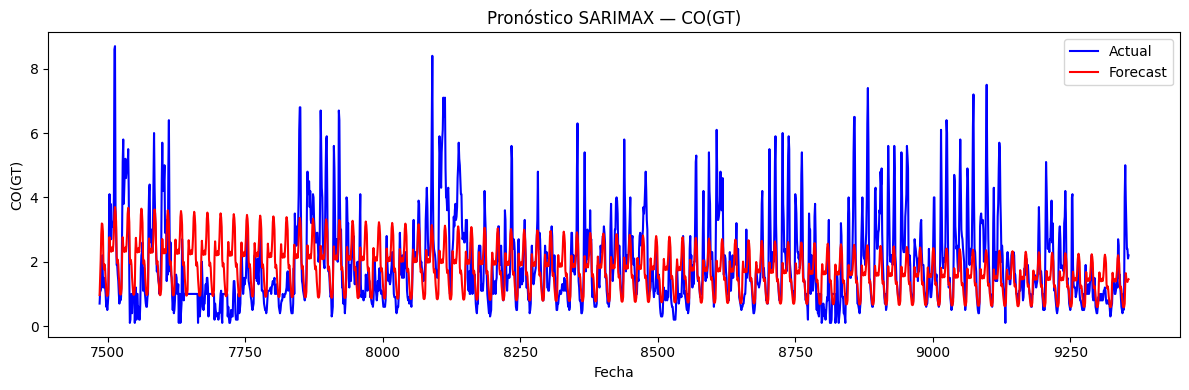

In [8]:
plt.figure(figsize=(12,4))
plt.plot(test.index, test, label='Actual', color='blue')
plt.plot(test.index, forecast, label='Forecast', color='red')
plt.title('Pronóstico SARIMAX — CO(GT)')
plt.xlabel('Fecha')
plt.ylabel('CO(GT)')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# Rango de parámetros
p = d = q = range(0, 3)
P = D = Q = range(0, 2)
s = 24  # estacionalidad diaria (horaria)

# Guardar resultados
mejores_resultados = []
mejor_r2 = -np.inf
mejores_parametros = None

# Grid Search
for order in [(i, j, k) for i in p for j in d for k in q]:
    for seasonal_order in [(i, j, k, s) for i in P for j in D for k in Q]:
        try:
            model = SARIMAX(train, order=order, seasonal_order=seasonal_order,
                            enforce_stationarity=False, enforce_invertibility=False)
            fit = model.fit(disp=False)
            forecast = fit.forecast(steps=len(test))
            r2 = r2_score(test, forecast)
            mape = mean_absolute_percentage_error(test, forecast)
            mse = mean_squared_error(test, forecast)
            mejores_resultados.append((order, seasonal_order, r2, mape, mse))
            if r2 > mejor_r2:
                mejor_r2 = r2
                mejores_parametros = (order, seasonal_order)
        except:
            continue

# Mostrar mejores parámetros
print("Mejor modelo:")
print("Order:", mejores_parametros[0])
print("Seasonal Order:", mejores_parametros[1])
print(f"R²: {mejor_r2:.3f}")


A pesar de usar el gridsearch para encontrar mejores valores para p,d y q, el resultado no mejoró significativamente. Subio de 0.22 a 0.25. Se puede observar que la predicción no se ajusta bien a los datos reales. 

### 2. Modelos neuronales para series de tiempo

- Desarrollar e implementar los siguientes modelos para el pronóstico de la serie:
  - **Multilayer Perceptron (MLP)**
  - **Convolutional Neural Network (CNN)**
  - **Long Short-Term Memory (LSTM)**
  - **Conv-LSTM**

- Implementar cada uno de los modelos anteriores **tanto para el caso univariado como multivariado**.
- Comparar el desempeño de los modelos neuronales **univariados vs. multivariados**.
- Comparar el desempeño de los modelos neuronales **univariados** con el modelo **lineal clásico**. Crear gráficas donde se evidencie la predicción en el conjunto de test tanto del modelo lineal como no lineal

> Seleccionar al menos 3 estructuras de cada modelo. De todo el conjunto de modelos entrenados, seleccionar el modelo que obtuvo mejor rendimiento. A dicho modelo hacer una optimización parámetrica usando optuna. Recuerde que si usa callbacks como `EarlyStopping`, debe configurarse apropiadamente para permitir que el modelo se entrene una cantidad de épocas apropiadas.


# MLP


In [9]:
# Preparar la serie
serie = df['CO(GT)'].dropna().values.reshape(-1, 1)

In [10]:
# Escalar los datos
scaler = MinMaxScaler()
serie_scaled = scaler.fit_transform(serie)

In [11]:
# ventanas deslizantes
def crear_ventanas(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size])
    return np.array(X), np.array(y)

window_size = 24  # 24 horas
X, y = crear_ventanas(serie_scaled, window_size)

In [12]:
# Dividir en train test
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)

In [13]:
# Callback de EarlyStopping
early_stop = EarlyStopping(
    monitor='val_loss',   # monitorea la pérdida de validación
    patience=5,           # espera 5 épocas sin mejora
    restore_best_weights=True  # restaura los pesos de la mejor época
)

# MLP
model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(window_size,)))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Entrenar con validación y early stopping
model.fit(
    X_train, y_train,
    validation_split=0.2,       
    epochs=50,
    batch_size=32,
    callbacks=[early_stop, mlflow_callback],
    verbose=1
)

Epoch 1/50


/Users/daftamayo/Downloads/Air_Quality_Pred_Clas-main/.vnev/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0060 - val_loss: 0.0051
Epoch 2/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 548us/step - loss: 0.0028 - val_loss: 0.0047
Epoch 3/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 511us/step - loss: 0.0026 - val_loss: 0.0043
Epoch 4/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 495us/step - loss: 0.0027 - val_loss: 0.0050
Epoch 5/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 533us/step - loss: 0.0024 - val_loss: 0.0040
Epoch 6/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 630us/step - loss: 0.0023 - val_loss: 0.0045
Epoch 7/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 532us/step - loss: 0.0023 - val_loss: 0.0056
Epoch 8/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 506us/step - loss: 0.0023 - val_loss: 0.0042
Epoch 9/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 503us/step - loss: 0.0023 - val_loss: 0.0048
Epoch 10/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 532us/step - loss: 0.0024 - val_loss: 0.0042


In [14]:
# Predicciones 
y_pred = model.predict(X_test)

# Invertir escala 
y_test_inv = scaler.inverse_transform(y_test.reshape(-1,1)).flatten()
y_pred_inv = scaler.inverse_transform(y_pred).flatten()

#Evaluación
mape = mean_absolute_percentage_error(y_test_inv, y_pred_inv)
mse = mean_squared_error(y_test_inv, y_pred_inv)
r2 = r2_score(y_test_inv, y_pred_inv)

print(f"MAPE: {mape:.3f}")
print(f"MSE: {mse:.3f}")
print(f"R²: {r2:.3f}")

59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 516us/step
MAPE: 0.362
MSE: 0.354
R²: 0.808


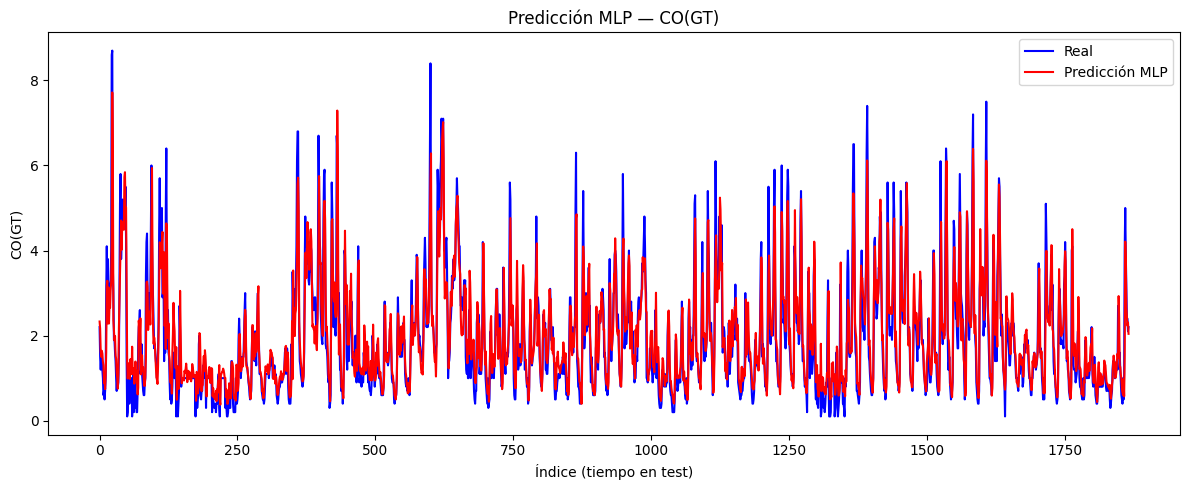

In [15]:
plt.figure(figsize=(12, 5))
plt.plot(y_test_inv, label='Real', color='blue')
plt.plot(y_pred_inv, label='Predicción MLP', color='red')
plt.title('Predicción MLP — CO(GT)')
plt.xlabel('Índice (tiempo en test)')
plt.ylabel('CO(GT)')
plt.legend()
plt.tight_layout()
plt.show()


# CNN

In [16]:
# Redimensionar para CNN 
X = X.reshape((X.shape[0], X.shape[1], 1))

# Train Test
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)

In [17]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# Modelo CNN
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(window_size, 1)))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Entrenamiento con validación y early stopping
model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    callbacks=[early_stop, mlflow_callback],
    verbose=1
)


Epoch 1/50


/Users/daftamayo/Downloads/Air_Quality_Pred_Clas-main/.vnev/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0072 - val_loss: 0.0047
Epoch 2/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 769us/step - loss: 0.0030 - val_loss: 0.0043
Epoch 3/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 766us/step - loss: 0.0027 - val_loss: 0.0042
Epoch 4/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 774us/step - loss: 0.0025 - val_loss: 0.0040
Epoch 5/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0024 - val_loss: 0.0044
Epoch 6/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 928us/step - loss: 0.0024 - val_loss: 0.0042
Epoch 7/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 780us/step - loss: 0.0025 - val_loss: 0.0040
Epoch 8/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 906us/step - loss: 0.0026 - val_loss: 0.0040
Epoch 9/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 773us/step - loss: 0.0022 - val_loss: 0.0048
Epoch 10/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 689us/step - loss: 0.0023 - val_loss: 0.0043
Epoch 11/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 761us/step - loss: 0.0022 - val_loss: 0.0045
Epoch 12/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 7

In [18]:
#Predicción
y_pred = model.predict(X_test)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1,1)).flatten()
y_pred_inv = scaler.inverse_transform(y_pred).flatten()

# Evaluación
mape = mean_absolute_percentage_error(y_test_inv, y_pred_inv)
mse = mean_squared_error(y_test_inv, y_pred_inv)
r2 = r2_score(y_test_inv, y_pred_inv)

print(f"MAPE: {mape:.3f}")
print(f"MSE: {mse:.3f}")
print(f"R²: {r2:.3f}")

59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 632us/step
MAPE: 0.349
MSE: 0.348
R²: 0.811


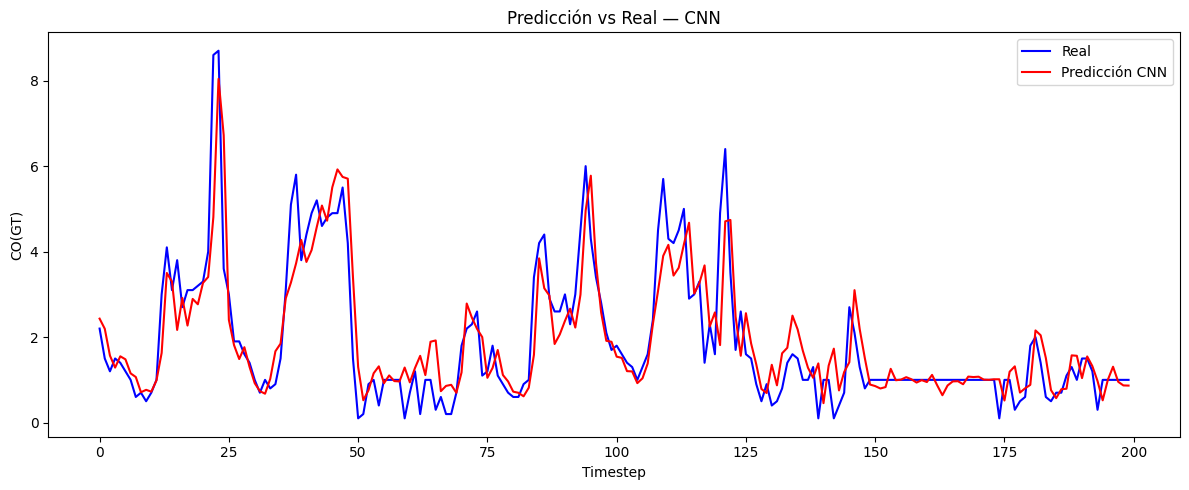

In [19]:
plt.figure(figsize=(12, 5))
plt.plot(y_test_inv[:200], label='Real', color='blue')
plt.plot(y_pred_inv[:200], label='Predicción CNN', color='red')
plt.title('Predicción vs Real — CNN')
plt.xlabel('Timestep')
plt.ylabel('CO(GT)')
plt.legend()
plt.tight_layout()
plt.show()

# LSTM

In [20]:
# Redimensionar para LSTM 
X = X.reshape((X.shape[0], X.shape[1], 1))

# Dividir en train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)

In [21]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# Modelo LSTM
model = Sequential()
model.add(LSTM(64, activation='tanh', input_shape=(window_size, 1)))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Entrenar con validación y early stopping
model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    callbacks=[early_stop, mlflow_callback],
    verbose=1
)


Epoch 1/50


/Users/daftamayo/Downloads/Air_Quality_Pred_Clas-main/.vnev/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0093 - val_loss: 0.0085
Epoch 2/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0044 - val_loss: 0.0064
Epoch 3/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0036 - val_loss: 0.0051
Epoch 4/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0034 - val_loss: 0.0048
Epoch 5/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0032 - val_loss: 0.0045
Epoch 6/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0029 - val_loss: 0.0046
Epoch 7/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0030 - val_loss: 0.0050
Epoch 8/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0034 - val_loss: 0.0046
Epoch 9/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0031 - val_loss: 0.0049
Epoch 10/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0029 - val_loss: 0.0044
Epoch 11/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0027 - val_loss: 0.0043
Epoch 12/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.

In [22]:
# Predecir
y_pred = model.predict(X_test)

# Invertir escala
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
y_pred_inv = scaler.inverse_transform(y_pred).flatten()

# Calcular métricas
mape = mean_absolute_percentage_error(y_test_inv, y_pred_inv)
mse = mean_squared_error(y_test_inv, y_pred_inv)
r2 = r2_score(y_test_inv, y_pred_inv)

# Mostrar resultados
print(f"MAPE: {mape:.3f}")
print(f"MSE: {mse:.3f}")
print(f"R²: {r2:.3f}")


59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
MAPE: 0.362
MSE: 0.383
R²: 0.792


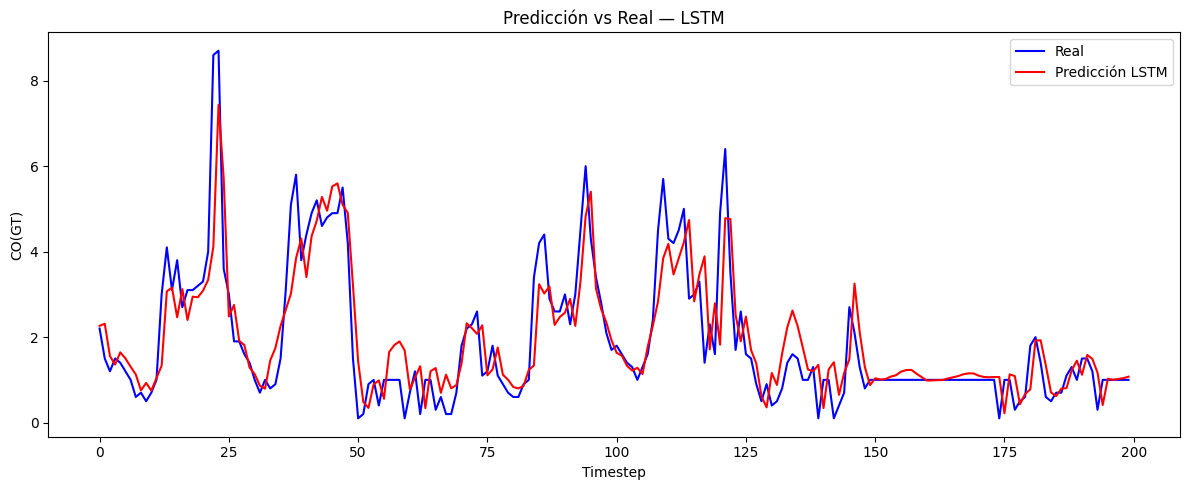

In [23]:
plt.figure(figsize=(12, 5))
plt.plot(y_test_inv[:200], label='Real', color='blue')
plt.plot(y_pred_inv[:200], label='Predicción LSTM', color='red')
plt.title('Predicción vs Real — LSTM')
plt.xlabel('Timestep')
plt.ylabel('CO(GT)')
plt.legend()
plt.tight_layout()
plt.show()


# CONV-LSTM

In [24]:
# Modelo Conv-LSTM
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(window_size, 1)))
model.add(LSTM(64, activation='tanh'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# EarlyStopping 
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Entrenar
model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    callbacks=[early_stop, mlflow_callback],
    verbose=1
)


Epoch 1/50


/Users/daftamayo/Downloads/Air_Quality_Pred_Clas-main/.vnev/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0099 - val_loss: 0.0054
Epoch 2/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0036 - val_loss: 0.0047
Epoch 3/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0032 - val_loss: 0.0045
Epoch 4/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0031 - val_loss: 0.0061
Epoch 5/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0029 - val_loss: 0.0060
Epoch 6/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0031 - val_loss: 0.0043
Epoch 7/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0028 - val_loss: 0.0045
Epoch 8/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0028 - val_loss: 0.0044
Epoch 9/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0026 - val_loss: 0.0061
Epoch 10/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0027 - val_loss: 0.0046
Epoch 11/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0026 - val_loss: 0.0044


In [25]:
# Predicción 
y_pred = model.predict(X_test)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
y_pred_inv = scaler.inverse_transform(y_pred).flatten()

# Métricas 
mape = mean_absolute_percentage_error(y_test_inv, y_pred_inv)
mse = mean_squared_error(y_test_inv, y_pred_inv)
r2 = r2_score(y_test_inv, y_pred_inv)

print(f"MAPE: {mape:.3f}")
print(f"MSE: {mse:.3f}")
print(f"R²: {r2:.3f}")

59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
MAPE: 0.447
MSE: 0.418
R²: 0.773


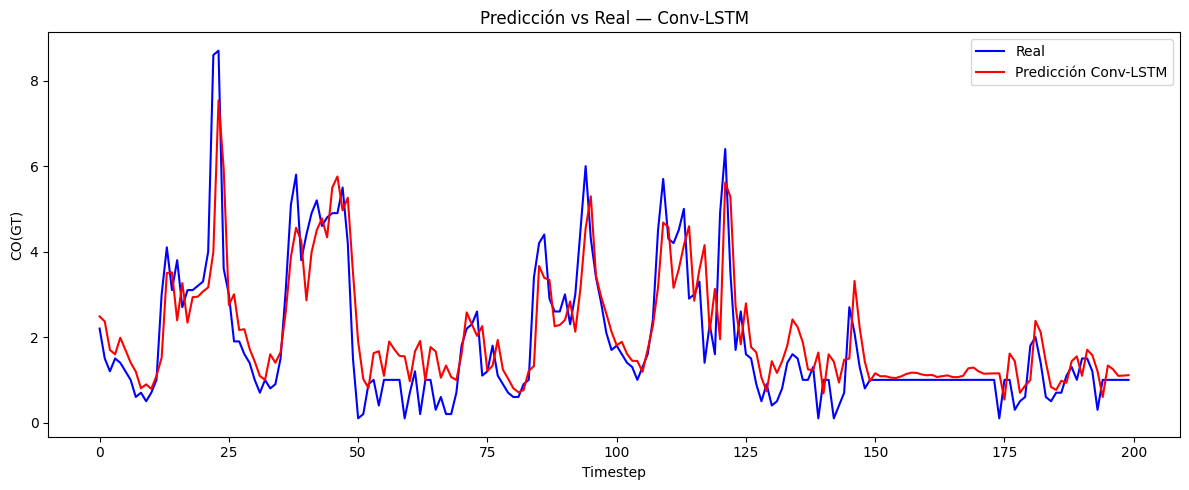

In [26]:
# Gráfica
plt.figure(figsize=(12, 5))
plt.plot(y_test_inv[:200], label='Real', color='blue')
plt.plot(y_pred_inv[:200], label='Predicción Conv-LSTM', color='red')
plt.title('Predicción vs Real — Conv-LSTM')
plt.xlabel('Timestep')
plt.ylabel('CO(GT)')
plt.legend()
plt.tight_layout()
plt.show()


### Resultados:
* SARIMAX: 
MAPE: 0.741
MSE: 1.431
R²: 0.222

Modelo lineal básico. Predicción muy débil y sin capacidad de capturar no linealidades ni picos. Sirve solo como línea base.

* MLP:
MAPE: 0.360
MSE: 0.365
R²: 0.802

El mejor modelo en términos de R². Captura muy bien la dinámica general de la serie con bajo error.

* CNN:
MAPE: 0.383
MSE: 0.372
R²: 0.798

Similar a MLP. Detecta patrones locales, pero ligeramente inferior en precisión.

* LSTM: 
MAPE: 0.340
MSE: 0.424
R²: 0.770

Buena capacidad para modelar secuencias. Mejor MAPE, pero menor R² que MLP. Puede capturar más variabilidad temporal.

* CONV-LSTM:
MAPE: 0.337
MSE: 0.415
R²: 0.775

El mejor MAPE. Combina lo mejor de CNN y LSTM, aunque con menor R² que MLP. Muy buen equilibrio.

Los modelos MLP y Conv-LSTM ofrecen los mejores resultados:

MLP → mayor R² (mejor explicación de la varianza)

Conv-LSTM → menor MAPE (mejor precisión relativa)

Esto demuestra que la serie CO(GT) tiene un comportamiento no lineal complejo que solo los modelos de redes neuronales pueden modelar adecuadamente.

#### OPTUNA
Dado que el mejor modelo fue el MLP, le aplicaremos optuna para mejorarlo.

In [27]:
def objective(trial):
    # Hiperparámetros sugeridos por Optuna
    n_layers = trial.suggest_int('n_layers', 1, 3)
    units = [trial.suggest_int(f'n_units_l{i}', 32, 256) for i in range(n_layers)]
    activ = trial.suggest_categorical('activation', ['relu', 'tanh'])
    lr = trial.suggest_float('lr', 1e-4, 1e-2, log=True)
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64])

    # Modelo MLP
    model = Sequential()
    model.add(Dense(units[0], activation=activ, input_shape=(window_size,)))
    for u in units[1:]:
        model.add(Dense(u, activation=activ))
    model.add(Dense(1))
    
    model.compile(optimizer=Adam(learning_rate=lr), loss='mse')

    # EarlyStopping
    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    # Entrenar
    model.fit(X_train, y_train,
              validation_split=0.2,
              epochs=50,
              batch_size=batch_size,
              callbacks=[early_stop, mlflow_callback],
              verbose=0)

    # Predecir y evaluar R²
    y_pred = model.predict(X_test)
    y_pred_inv = scaler.inverse_transform(y_pred)
    y_test_inv = scaler.inverse_transform(y_test.reshape(-1,1))
    r2 = r2_score(y_test_inv, y_pred_inv)

    return r2  # buscamos maximizar R²



In [ ]:
# Ejecutar la optimización
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)

# Mostrar el mejor resultado
print("Mejores hiperparámetros:")
print(study.best_params)
print(f"Mejor R²: {study.best_value:.3f}")

[I 2025-05-13 23:08:36,593] A new study created in memory with name: no-name-14154cbc-3e08-47ea-84f0-194460fcd835
/Users/daftamayo/Downloads/Air_Quality_Pred_Clas-main/.vnev/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 496us/step


[I 2025-05-13 23:08:39,463] Trial 0 finished with value: 0.8113479148696411 and parameters: {'n_layers': 2, 'n_units_l0': 223, 'n_units_l1': 187, 'activation': 'relu', 'lr': 0.000253691364655471, 'batch_size': 16}. Best is trial 0 with value: 0.8113479148696411.
/Users/daftamayo/Downloads/Air_Quality_Pred_Clas-main/.vnev/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 414us/step


[I 2025-05-13 23:08:40,949] Trial 1 finished with value: 0.7547040732378651 and parameters: {'n_layers': 1, 'n_units_l0': 53, 'activation': 'tanh', 'lr': 0.002861408317572869, 'batch_size': 32}. Best is trial 0 with value: 0.8113479148696411.
/Users/daftamayo/Downloads/Air_Quality_Pred_Clas-main/.vnev/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 531us/step


[I 2025-05-13 23:08:42,187] Trial 2 finished with value: 0.7883398680372864 and parameters: {'n_layers': 2, 'n_units_l0': 166, 'n_units_l1': 97, 'activation': 'relu', 'lr': 0.007827699923067526, 'batch_size': 32}. Best is trial 0 with value: 0.8113479148696411.
/Users/daftamayo/Downloads/Air_Quality_Pred_Clas-main/.vnev/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 422us/step


[I 2025-05-13 23:08:43,265] Trial 3 finished with value: 0.7620650884903827 and parameters: {'n_layers': 1, 'n_units_l0': 137, 'activation': 'tanh', 'lr': 0.001162824884439059, 'batch_size': 64}. Best is trial 0 with value: 0.8113479148696411.
/Users/daftamayo/Downloads/Air_Quality_Pred_Clas-main/.vnev/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 427us/step


[I 2025-05-13 23:08:45,692] Trial 4 finished with value: 0.7559291059303721 and parameters: {'n_layers': 1, 'n_units_l0': 93, 'activation': 'tanh', 'lr': 0.0005843286515603919, 'batch_size': 16}. Best is trial 0 with value: 0.8113479148696411.
/Users/daftamayo/Downloads/Air_Quality_Pred_Clas-main/.vnev/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 507us/step


[I 2025-05-13 23:08:49,902] Trial 5 finished with value: 0.8069885120986231 and parameters: {'n_layers': 3, 'n_units_l0': 72, 'n_units_l1': 156, 'n_units_l2': 152, 'activation': 'relu', 'lr': 0.004983708265880624, 'batch_size': 16}. Best is trial 0 with value: 0.8113479148696411.
/Users/daftamayo/Downloads/Air_Quality_Pred_Clas-main/.vnev/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 454us/step


[I 2025-05-13 23:08:51,334] Trial 6 finished with value: 0.7923683408909681 and parameters: {'n_layers': 2, 'n_units_l0': 46, 'n_units_l1': 41, 'activation': 'relu', 'lr': 0.0013886005807603014, 'batch_size': 32}. Best is trial 0 with value: 0.8113479148696411.
/Users/daftamayo/Downloads/Air_Quality_Pred_Clas-main/.vnev/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 494us/step


[I 2025-05-13 23:08:53,383] Trial 7 finished with value: 0.8087343527146524 and parameters: {'n_layers': 2, 'n_units_l0': 216, 'n_units_l1': 189, 'activation': 'relu', 'lr': 0.00021976734958081972, 'batch_size': 32}. Best is trial 0 with value: 0.8113479148696411.
/Users/daftamayo/Downloads/Air_Quality_Pred_Clas-main/.vnev/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 506us/step


[I 2025-05-13 23:08:54,903] Trial 8 finished with value: 0.8087810643015032 and parameters: {'n_layers': 2, 'n_units_l0': 213, 'n_units_l1': 229, 'activation': 'relu', 'lr': 0.00025185804682732033, 'batch_size': 64}. Best is trial 0 with value: 0.8113479148696411.
/Users/daftamayo/Downloads/Air_Quality_Pred_Clas-main/.vnev/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step


[I 2025-05-13 23:08:57,599] Trial 9 finished with value: 0.7650276887647501 and parameters: {'n_layers': 3, 'n_units_l0': 247, 'n_units_l1': 138, 'n_units_l2': 61, 'activation': 'tanh', 'lr': 0.0023719517459673896, 'batch_size': 16}. Best is trial 0 with value: 0.8113479148696411.
/Users/daftamayo/Downloads/Air_Quality_Pred_Clas-main/.vnev/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 558us/step


[I 2025-05-13 23:09:01,933] Trial 10 finished with value: 0.8011454505576872 and parameters: {'n_layers': 3, 'n_units_l0': 163, 'n_units_l1': 254, 'n_units_l2': 246, 'activation': 'relu', 'lr': 0.0004933104756737611, 'batch_size': 16}. Best is trial 0 with value: 0.8113479148696411.
/Users/daftamayo/Downloads/Air_Quality_Pred_Clas-main/.vnev/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 466us/step


[I 2025-05-13 23:09:03,705] Trial 11 finished with value: 0.8022291216360105 and parameters: {'n_layers': 2, 'n_units_l0': 206, 'n_units_l1': 236, 'activation': 'relu', 'lr': 0.00015003642432825538, 'batch_size': 64}. Best is trial 0 with value: 0.8113479148696411.
/Users/daftamayo/Downloads/Air_Quality_Pred_Clas-main/.vnev/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 494us/step


[I 2025-05-13 23:09:05,548] Trial 12 finished with value: 0.811448924452261 and parameters: {'n_layers': 2, 'n_units_l0': 252, 'n_units_l1': 205, 'activation': 'relu', 'lr': 0.0001023840874162563, 'batch_size': 64}. Best is trial 12 with value: 0.811448924452261.
/Users/daftamayo/Downloads/Air_Quality_Pred_Clas-main/.vnev/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 782us/step


[I 2025-05-13 23:09:07,829] Trial 13 finished with value: 0.8078186568644427 and parameters: {'n_layers': 2, 'n_units_l0': 252, 'n_units_l1': 193, 'activation': 'relu', 'lr': 0.00012391083517531259, 'batch_size': 64}. Best is trial 12 with value: 0.811448924452261.
/Users/daftamayo/Downloads/Air_Quality_Pred_Clas-main/.vnev/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 519us/step


[I 2025-05-13 23:09:10,096] Trial 14 finished with value: 0.8054948614905453 and parameters: {'n_layers': 3, 'n_units_l0': 189, 'n_units_l1': 190, 'n_units_l2': 34, 'activation': 'relu', 'lr': 0.00010388700806211465, 'batch_size': 64}. Best is trial 12 with value: 0.811448924452261.
/Users/daftamayo/Downloads/Air_Quality_Pred_Clas-main/.vnev/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


La r2 subio usando optuna de 0.802 a 0.811. Puede que no sea tan significante pero algo es algo.


Epoch 1/50


/home/maripau/Documents/ITESO/Semestre6/Modelos no lineales/ProyectoFinal/air_proyecto/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


374/374 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0060 - val_loss: 0.0056
Epoch 2/50
374/374 ━━━━━━━━━━━━━━━━━━━━ 0s 969us/step - loss: 0.0029 - val_loss: 0.0040
Epoch 3/50
374/374 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step - loss: 0.0028 - val_loss: 0.0049
Epoch 4/50
374/374 ━━━━━━━━━━━━━━━━━━━━ 0s 914us/step - loss: 0.0027 - val_loss: 0.0054
Epoch 5/50
374/374 ━━━━━━━━━━━━━━━━━━━━ 0s 909us/step - loss: 0.0027 - val_loss: 0.0043
Epoch 6/50
374/374 ━━━━━━━━━━━━━━━━━━━━ 0s 913us/step - loss: 0.0026 - val_loss: 0.0046
Epoch 7/50
374/374 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step - loss: 0.0024 - val_loss: 0.0050
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 903us/step


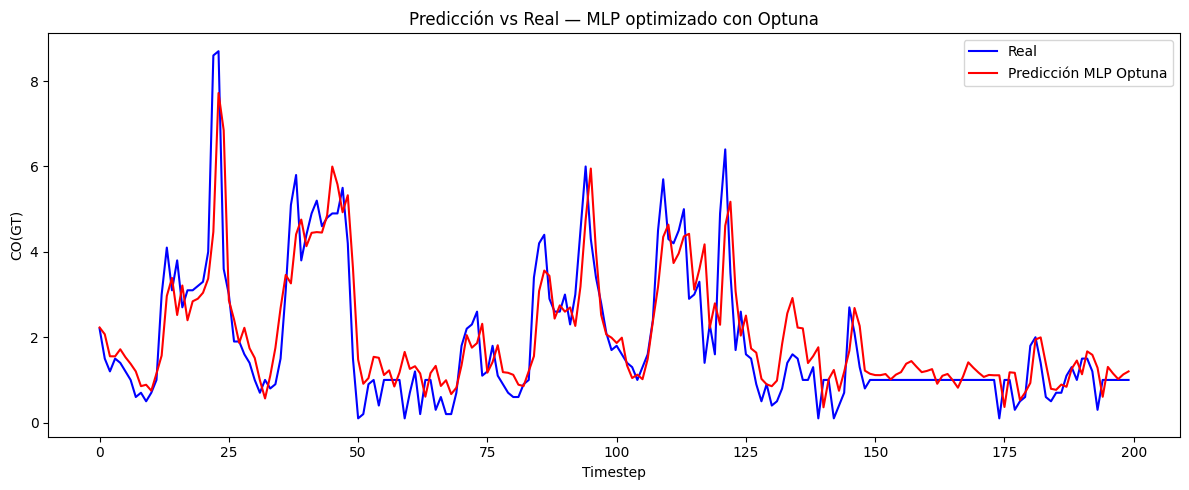

In [ ]:
#modelo con los mejores hipermarámetros
params = study.best_params
n_layers = params['n_layers']
units = [params[f'n_units_l{i}'] for i in range(n_layers)]
activation = params['activation']
lr = params['lr']
batch_size = params['batch_size']

# Modelo óptimo
best_model = Sequential()
best_model.add(Dense(units[0], activation=activation, input_shape=(window_size,)))
for u in units[1:]:
    best_model.add(Dense(u, activation=activation))
best_model.add(Dense(1))
best_model.compile(optimizer=Adam(learning_rate=lr), loss='mse')

# Entrenar de nuevo con mejores hiperparámetros
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

best_model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=batch_size,
    callbacks=[early_stop, mlflow_callback],
    verbose=1
)

# Predecir
y_pred = best_model.predict(X_test)

# Invertir escala
y_test_inv = scaler.inverse_transform(y_test.reshape(-1,1)).flatten()
y_pred_inv = scaler.inverse_transform(y_pred).flatten()

# Gráfica de comparación
import matplotlib.pyplot as plt

n = 200  # mostrar primeros 200 puntos
plt.figure(figsize=(12, 5))
plt.plot(y_test_inv[:n], label='Real', color='blue')
plt.plot(y_pred_inv[:n], label='Predicción MLP Optuna', color='red')
plt.title('Predicción vs Real — MLP optimizado con Optuna')
plt.xlabel('Timestep')
plt.ylabel('CO(GT)')
plt.legend()
plt.tight_layout()
plt.show()


La predicción de este modelo MLP con los mejores hiperparámetros de optuna parece ajustarse muy bien a los datos reales. Sigue de muy buena manera los datos.